##### Imports & Global Variables

In [7]:
# %pip install -r requirements.txt

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel

In [9]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)

# Getting Data

In [3]:
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

index_close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[index_close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

sp500_prices = index_close_prices['S&P 500'].dropna()

In [4]:
# index_close_prices.apply(lambda col: col.dropna().index[0])

# Testing KAMA

In [15]:
kama = KAMA(n=10, n_fast=2, n_slow=30)
sp500_kama = kama.calculate_kama(sp500_prices)
# pd.concat([sp500_prices, sp500_kama[0], sp500_kama[1], sp500_kama[2]], axis=1).head(11)

px.line(pd.concat([sp500_prices, sp500_kama[0]], axis=1).tail(252*5))

# Testing MSR

Fitting Markov Switching Model on S&P 500 data...
Running Gibbs sampler: 275 total iterations
Burnin: 75, Samples: 200, Thin: 1
Iteration 25/275
Iteration 50/275
Iteration 75/275
Iteration 100/275
Iteration 125/275
Iteration 150/275
Iteration 175/275
Iteration 200/275
Iteration 225/275
Iteration 250/275
Iteration 275/275

Gibbs sampling completed!
Regime 0: μ=0.000724, β=-0.0010, σ=0.006530
Regime 1: μ=-0.000720, β=-0.0105, σ=0.017227

ANALYSIS RESULTS FOR S&P 500

Estimated Parameters:
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000724    -0.0010   0.006530   
Regime 1  -0.000720   -0.0105   0.017227   

Transition Probabilities:
From\To   Regime 0   Regime 1
Regime 0    0.983      0.017
Regime 1    0.038      0.962

Expected Regime Durations:
Regime 0 (Low Vol): 58.1 days
Regime 1 (High Vol): 26.3 days

Regime Classification:
Estimated Regime 0 periods: 4911 days (69.6%)
Estimated Regime 1 periods: 2144 days (30.4%)

Empiric

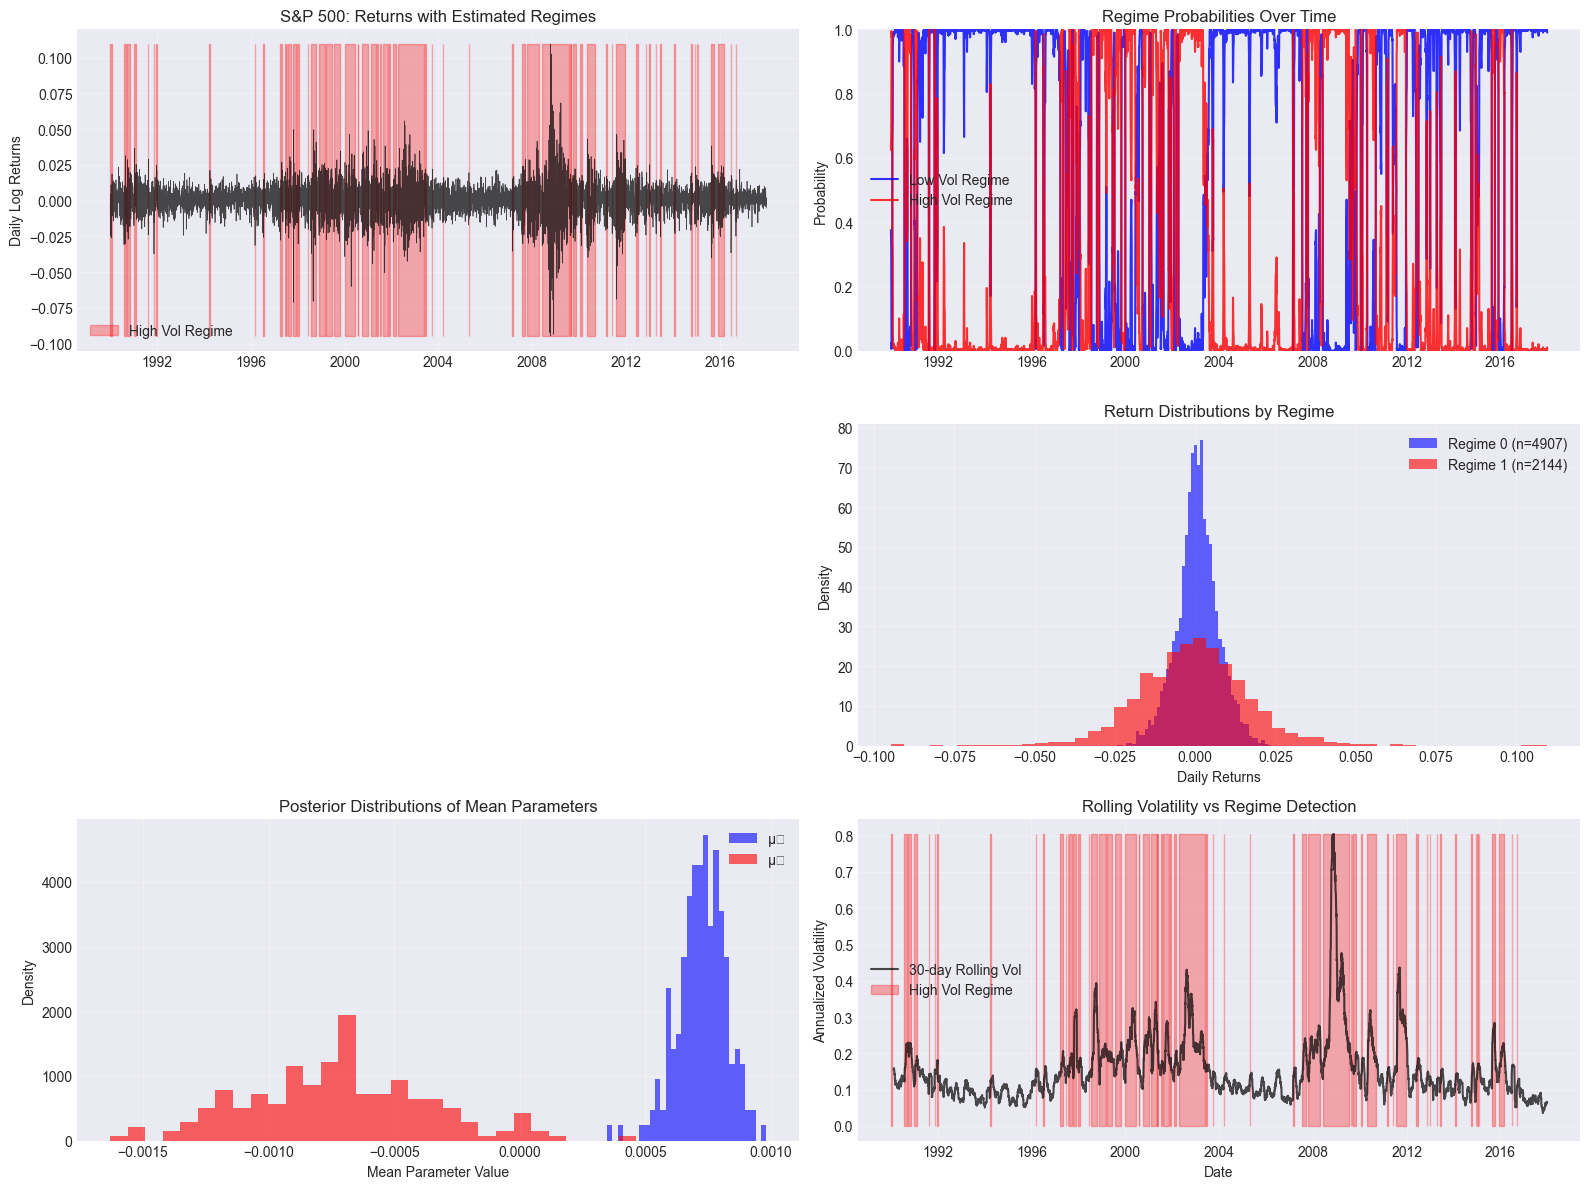


DETAILED REGIME ANALYSIS - S&P 500

Low Volatility Regime (Regime 0):
  Observations: 4911 (69.6%)
  Mean Return: 0.000741 (18.68% annualized)
  Volatility: 0.006492 (10.31% annualized)
  Min Return: -0.024293
  Max Return: 0.023513
  Skewness: -0.060
  Excess Kurtosis: 0.518

High Volatility Regime (Regime 1):
  Observations: 2144 (30.4%)
  Mean Return: -0.000763 (-19.22% annualized)
  Volatility: 0.017504 (27.79% annualized)
  Min Return: -0.094695
  Max Return: 0.109572
  Skewness: -0.048
  Excess Kurtosis: 3.177

Regime Switching Frequency:
  Number of regime changes: 123
  Average regime duration: 56.9 days

MODEL DIAGNOSTICS - S&P 500

Model Fit Statistics:
Approximate Log-Likelihood: 23395.87
Approximate (Average) Log-Likelihood: 3.32

MCMC Convergence Diagnostics:
Number of samples: 200
μ_0 stability: First half = 0.000721, Second half = 0.000727
μ_1 stability: First half = -0.000777, Second half = -0.000664
β_0 stability: First half = -0.000851, Second half = -0.001243
β_1 st

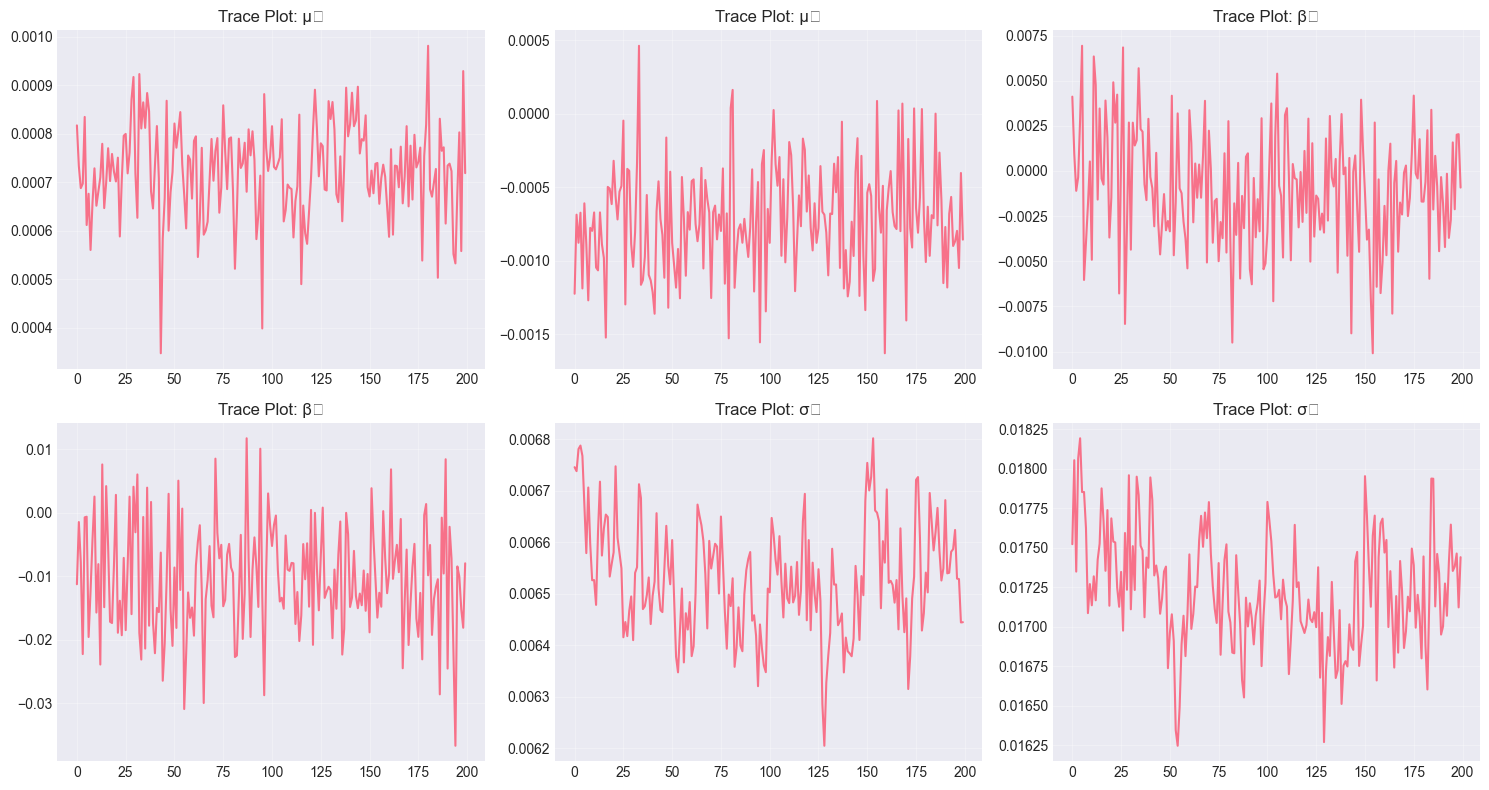


TESTING COMPLETE!


In [17]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)
# edte = sp500_prices.index[-1]
sp500_log_returns = np.log(sp500_prices.loc[sdte:edte]).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns})

model = MarkovSwitchingModel(n_regimes=2)
model.set_priors(
    mean_prior_mean=0.0,
    mean_prior_var=0.01,
    beta_prior_mean=0.0,
    beta_prior_var=0.3,
    sigma_prior_shape=3.0,
    sigma_prior_scale=0.0001,
    transition_prior_alpha=8.0
)
# Fit the model
print("Fitting Markov Switching Model on S&P 500 data...")
model.fit(sp500_log_returns['returns'], n_samples=200, burnin=75, verbose=True)

# Run comprehensive analysis
regime_probs = model.analyze_results(sp500_log_returns, data_name="S&P 500")

# Create visualizations
model.plot_results(sp500_log_returns, regime_probs, data_name="S&P 500")

# Detailed regime characteristics
regime_classification = model.regime_characteristics(sp500_log_returns, regime_probs, data_name="S&P 500")

# Model diagnostics
model.diagnostics(sp500_log_returns, regime_probs, data_name="S&P 500")

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)


# Next Section